# CMU 10714 Final Project Report - Deformable Vision Transformer in Needle

**Group 13 Members**:  
- Patrick Chen (Email: bochunc@andrew.cmu.edu)  
- Ricky Yuan (Email: rickyy@andrew.cmu.edu)  
- Daniel Yang (Email: danielya@andrew.cmu.edu)  

---

## Colab Environment Setup

Please run the following code cell to prepare for the whole executing environment for this project if you are using colab. It is required to run on a platform with GPU, e.g. T4. If you are not using colab, just skip the following running cell.
Or you can directly download the whole code of this project by accesing https://drive.google.com/uc?export=download&id=1q0Y5BZOR4HPLEjqaaODIsRnndHp3J0mL

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

# Create a project folder named 'project'
project_folder = "./10714_final_project_group13"
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"Folder '{project_folder}' created.")
else:
    print(f"Folder '{project_folder}' already exists.")

# Change the working directory to the project folder
os.chdir(project_folder)
print("Current working directory:", os.getcwd())

# Get the code file: project.zip
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1q0Y5BZOR4HPLEjqaaODIsRnndHp3J0mL" -O project.zip

# Unzip the code file: project.zip
!unzip project.zip -d .

# Install all the required packages.
!pip install -r requirements.txt --user

# Compile the cpu & cuda source code
!make

# Add our needle library to the system path.
import sys
sys.path.append('./python')

## Introduction
Vision Transformers (ViT) have emerged as a powerful alternative to convolutional neural networks for image recognition tasks. By leveraging the self-attention mechanism, ViT captures global context across an image, reducing the inductive biases inherent in convolutional approaches. This flexibility enables ViT to handle inputs of varying sizes and resolutions effectively through patch-based tokenization, making it a versatile choice for many vision applications.

However, traditional self-attention mechanisms in ViT are computationally intensive, due to the quadratic complexity of calculating global attention maps. To address these limitations, deformable attention mechanisms have been proposed. Deformable attention allows for sparse computation by focusing on a subset of key-value pairs, significantly reducing computational overhead while maintaining the flexibility and modeling capacity of the self-attention mechanism.

In this project, we implement a deformable attention layer within Vision Transformer using the **Needle** deep learning framework. Our goal is to explore how deformable attention can improve parameter efficiency and adaptiveness in modeling image features, especially for resource-constrained platforms. By integrating deformable attention into the ViT architecture, we aim to balance computational efficiency with competitive performance in image recognition tasks.

This report details our model architectures, implementations, experimental results, and findings. We evaluate our approach on the CIFAR-10 dataset and compare the performance of the baseline Vision Transformer with our deformable attention-enhanced model. Our experiments highlight the trade-offs between parameter efficiency, model complexity, and accuracy, providing valuable insights into the applicability of deformable attention in real-world scenarios.

## Model Architecture
The following figures show two model architectures that we implement in our Needle deep learning framework. The baseline model employs a standard Vision Transformer architecture with two transformer encoders employing global multi-head attention, capturing relationships across all image patches, as introduced in the ViT paper[<a href="#ref1">1</a>]. In contrast, the deformable attention model modifies this architecture by replacing one of the transformer encoder with a deformable attention layer[<a href="#ref2">2</a>], which focuses computation on a sparse subset of key-value pairs for improved efficiency.

Unlike the baseline model, which uniformly attends to all image patches, the deformable model adaptively samples and attends to the most relevant regions using an offset network and bilinear interpolation. This architectural difference allows us to explore how deformable attention mechanisms balance efficiency and performance. By designing these two distinct models, we aim to directly compare the capabilities of global and deformable attention mechanisms under the same framework. Such a comparison highlights the potential of deformable attention to focus on critical regions, addressing limitations of traditional global attention.

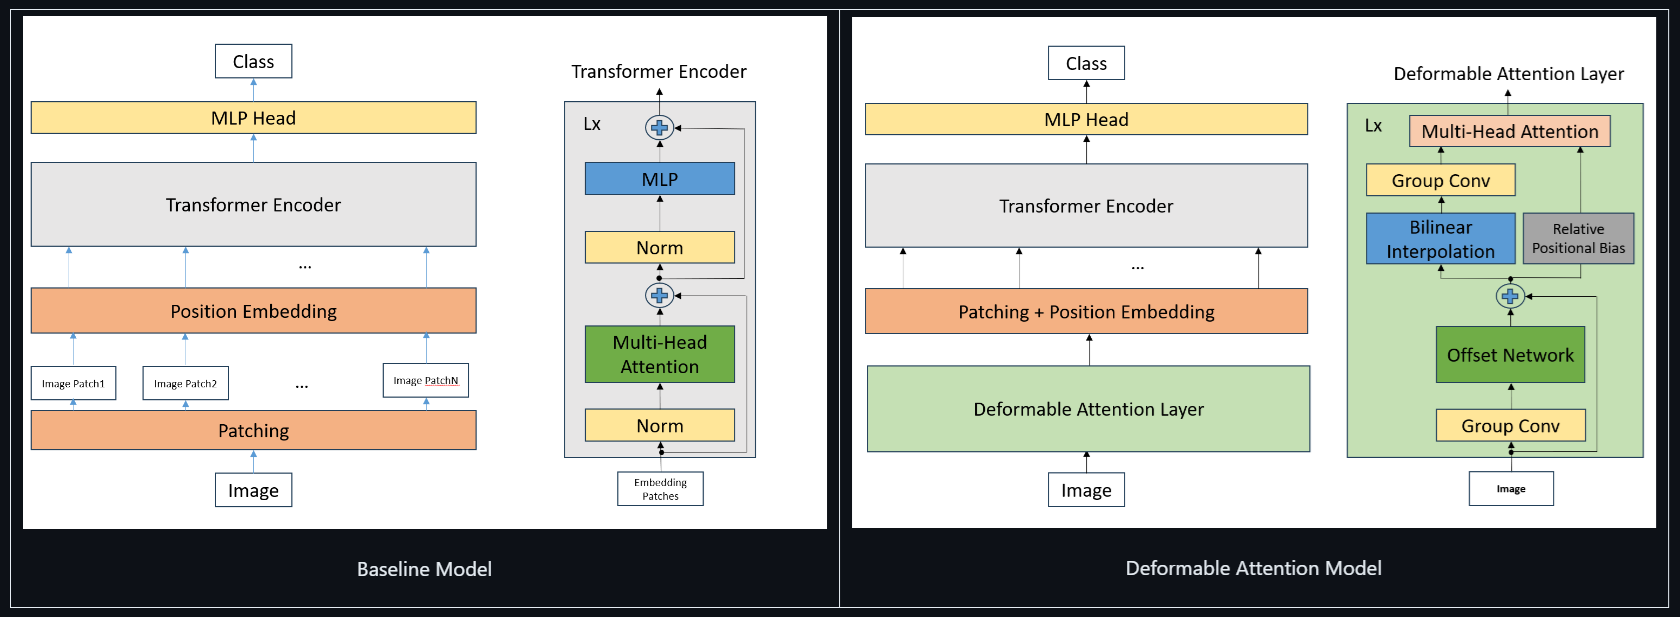

## Implementation
We divide our implementation into operations, sub-networks, deformable attention layer, and the final Vision Transformer model parts. Each implementation part includes the explanation prose, code location, and the pytest results.

### 1. Operations
#### 1.1. Group Convolution Operation
- **Explanation**:

**Group convolution** is a variation of the standard convolution operation in deep learning. It divides the input feature channels into smaller groups and applies convolution independently within each group. The outputs from all groups are then concatenated to form the final output. Our implementation firstly divide the input x, with shape (N, Cin, Hin, Win), and the parameter weight w along the channel axis using ops.split(). Secondly, w and x will be merged into groups with specified group number using ops.stack(). Lastly, these groups of w and x will then be applied to ops.conv() to perform the convolution. The output of the convolution will then be concatedated and transformed back to shape (N, Cout, Hout, Wout).

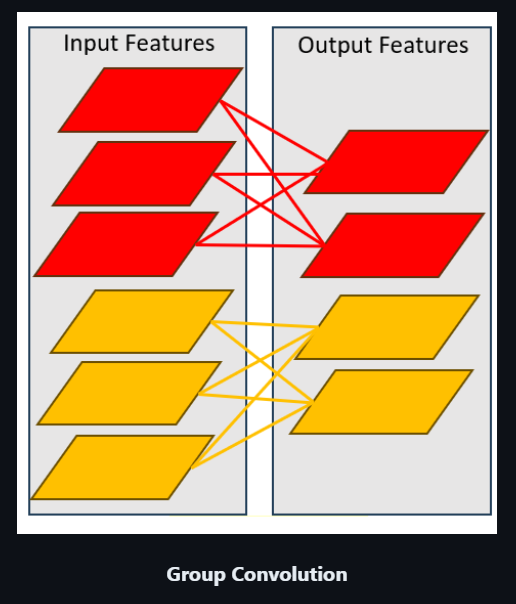

- **Code**:

Please check the implementation in `./python/needle/nn/nn_conv.py`. The class name is "ConvGP". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of group convolution in Pytorch.

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_group_conv"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 230 items / 86 deselected / 144 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_group_conv[needle.backend_ndarray.ndarray_backend_cpu-shape0-False-1-1-1-3-16] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_group_conv[needle.backend_ndarray.ndarray_backend_cpu-shape0-False-1-1-1-3-32] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_group_conv[needle.backend_ndarray.ndarray_backend_cpu-shape0-False-1-1-1-3-64] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_group_conv[needle.backend_ndarray.ndarray_backend_cpu-shape0-False-1-1-2-3-16] PASSED
tests/proj/test_deform_attn.py::test_de

#### 1.2. GELU Operation
- **Explanation**:

The **GELU (Gaussian Error Linear Unit)** activation function is mathematically defined as:


\begin{equation}
\text{GELU}(x) = x \cdot \Phi(x) \tag{1}
\end{equation}

where $\Phi(x)$ is the cumulative distribution function (CDF) of a standard normal distribution:

\begin{equation}
\Phi(x) = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{x}{\sqrt{2}} \right) \right] \tag{2}
\end{equation}

Here, $\text{erf}(\cdot)$ is the **error function**, which is a mathematical function used to compute probabilities under a normal distribution. However, due to the intensive computation of the above definition, it is generally prefered to implement the appriximation of GELU instead:

\begin{equation}
\text{GELU}(x) \approx 0.5x \left( 1 + \tanh\left( \sqrt{\frac{2}{\pi}} \left( x + 0.044715x^3 \right) \right) \right) \tag{3}
\end{equation}

This approximation is computationally efficient and close to the exact GELU function. We implement the approximated version in our needle.



- **Code**:

Please check the implementation in `./python/needle/nn/nn_deform_attention.py`. The class name is "GELU". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of GELU in Pytorch.

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_gelu"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 246 items / 230 deselected / 16 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_gelu[needle.backend_ndarray.ndarray_backend_cpu-shape0] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_gelu[needle.backend_ndarray.ndarray_backend_cpu-shape1] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_gelu[needle.backend_ndarray.ndarray_backend_cpu-shape2] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_gelu[needle.backend_ndarray.ndarray_backend_cpu-shape3] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_gelu[needle.backend_ndarray.ndarray_backend_cpu-shape4] PASSED
tests/proj/test_def

#### 1.3. Element-wised Absolute Operation
- **Explanation**:

The **element-wised absolute operation** applies the **absolute value function** to each element in a tensor (or NDarray) independently. This ensures that all elements become non-negative. The absolute operation is mathematically defined as:

\begin{equation}
|x_i| =
\begin{cases}
x_i, & \text{if } x_i \geq 0 \\
-x_i, & \text{if } x_i < 0
\end{cases}
\end{equation}

Where $|x_i|$ is the absolute value of $x_i$.


- **Code**:

Please check the implementation in `./python/needle/ops/ops_mathematics.py` and `./src/ndarray_backend_cpu.cc`. The function name is 'abs'. The implementation supports forward and backward calculations.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of abs() in Pytorch.

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_abs"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 246 items / 230 deselected / 16 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_abs[needle.backend_ndarray.ndarray_backend_cpu-shape0] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_abs[needle.backend_ndarray.ndarray_backend_cpu-shape1] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_abs[needle.backend_ndarray.ndarray_backend_cpu-shape2] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_abs[needle.backend_ndarray.ndarray_backend_cpu-shape3] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_abs[needle.backend_ndarray.ndarray_backend_cpu-shape4] PASSED
tests/proj/test_deform_a

#### 1.4. Element-wised Sign Operation
- **Explanation**:

The **element-wised `sign()` function** determines the sign of each element in a tensor (or array) independently. It outputs:
- \(1\) if the element is positive,
- \(-1\) if the element is negative,
- \(0\) if the element is zero.

For a tensor $x$ with elements $x_i$, the `sign()` function is defined as:

\begin{equation}
\text{sign}(x_i) =
\begin{cases}
1, & \text{if } x_i > 0 \\
0, & \text{if } x_i = 0 \\
-1, & \text{if } x_i < 0
\end{cases}
\end{equation}

- **Code**:

Please check the implementation in `./python/needle/ops/ops_mathematics.py` and `./src/ndarray_backend_cpu.cc`. The function name is 'sign'. The implementation supports forward and backward calculations.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of sign() in Pytorch.

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_sign"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 246 items / 230 deselected / 16 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_sign[needle.backend_ndarray.ndarray_backend_cpu-shape0] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_sign[needle.backend_ndarray.ndarray_backend_cpu-shape1] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_sign[needle.backend_ndarray.ndarray_backend_cpu-shape2] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_sign[needle.backend_ndarray.ndarray_backend_cpu-shape3] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_sign[needle.backend_ndarray.ndarray_backend_cpu-shape4] PASSED
tests/proj/test_def

#### 1.5. Bilinear Interpolation Operation
- **Explanation**:

**Bilinear Interpolation** is a resampling method that extends linear interpolation to two dimensions. It is commonly used in image processing to resize images, warp images, or calculate pixel values at non-integer positions.

Bilinear interpolation estimates the value of a point $(r, c)$ on a grid based on the values of the four nearest grid points. It interpolates first along one axis (e.g., row axis, r) and then along the other axis (e.g., column axis, c).

Let:
- $f(r, c)$, $f(r, c+1)$, $f(r+1, c)$, and $f(r+1, c+1)$ represent the values at the four nearest grid points.
- $\Delta r = r' - r$ and $\Delta c = c' - c$ represent the fractional distances of $(r', c')$ from $(r, c)$.

The interpolated value $f(r', c')$ is calculated in two steps:

1. **Interpolate along the rows** (horizontal interpolation):

   $
   f(r, c') = (1 - \Delta c) f(r, c) + \Delta c \cdot f(r, c+1)
   $

   $
   f(r+1, c') = (1 - \Delta c) f(r+1, c) + \Delta c \cdot f(r+1, c+1)
   $

2. **Interpolate along the column** (vertical interpolation):

   $
   f(r', c') = (1 - \Delta r) f(r, c') + \Delta r \cdot f(r+1, c')
   $

This formula computes $f(r', c')$ as a weighted average of its four neighbors based on the fractional distances $\Delta r$ and $\Delta c$.


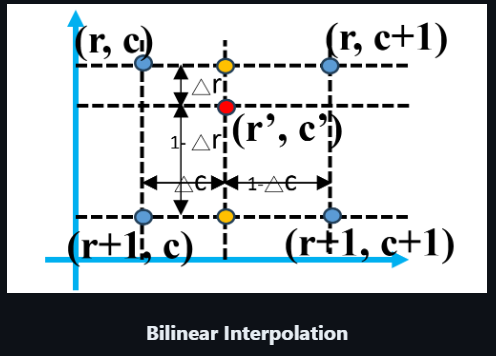

- **Code**:

Please check the implementation in `./python/needle/ops/ops_transforms.py` and `./src/ndarray_backend_cpu.cc`. The function name is 'grid_sample'. The implementation supports forward and backward calculations.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of grid_sample() in Pytorch.

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_nn_grid_sample"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 254 items / 246 deselected / 8 selected                              

tests/proj/test_deform_attn.py::test_nn_grid_sample[needle.backend_ndarray.ndarray_backend_cpu-False-zeros-bilinear-1-1-1-1-1-2] PASSED
tests/proj/test_deform_attn.py::test_nn_grid_sample[needle.backend_ndarray.ndarray_backend_cpu-False-zeros-bilinear-1-1-3-3-3-3] PASSED
tests/proj/test_deform_attn.py::test_nn_grid_sample[needle.backend_ndarray.ndarray_backend_cpu-False-zeros-bilinear-1-1-3-4-3-4] PASSED
tests/proj/test_deform_attn.py::test_nn_grid_sample[needle.backend_ndarray.ndarray_backend_cpu-False-zeros-bilinear-1-2-4-3-4-3] PASSED
tests/proj/test_deform_attn.py::tes

### 2. Subnetworks
#### 2.1. Offset Network
- **Explanation**:

The **Offset Network** is a sub-network in the Deformable Attention Layer of the Vision Transformer. Its primary role is to generate spatial offsets for sampling points, enabling the model to adaptively focus on important regions in the input feature map. By predicting offsets relative to predefined grid points, the network directs the attention mechanism to attend to task-relevant locations, improving efficiency and flexibility in representation learning.

Let $q \in \mathbb{R}^{H \times W \times C}$ be the input query features. The Offset Network generates spatial offsets $\Delta p \in \mathbb{R}^{H/r \times W/r \times 2}$ as follows:

$
\Delta p = \text{scale} \cdot \tanh\left(\text{Conv}_{\text{offset}}(q)\right),
$
where:
- $\text{Conv}_{\text{offset}}$ is a depthwise convolution, a group convolution with group = $C_{in}$ and each group contains exactly 1 input and output channel, followed by a non-linear activation (e.g., GELU) and another convolution.
- $\text{scale}$ ensures offsets remain within a stable range.

The offsets $\Delta p$ are added to the reference points $p$ to compute the new sampling locations:
$
p' = p + \Delta p.
$

These deformed sampling locations are then used in the deformable attention mechanism to extract features via bilinear interpolation.

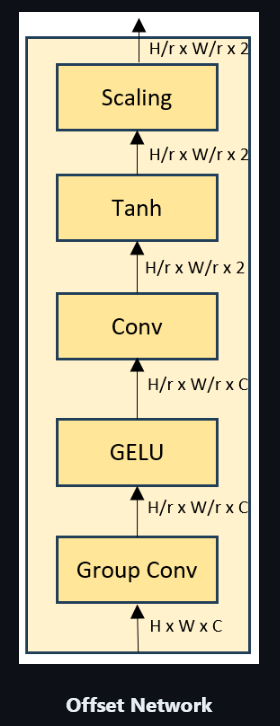

- **Code**:

Please check the implementation in `./python/needle/nn/nn_deform_attention.py`. The instance name is "self.to_offsets". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of a formal implementation of Deformable Attention (Lucidrain).

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_compare_lucid_our_offset or test_deform_attn_compare_lucid_our_normalized_grid"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 254 items / 238 deselected / 16 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_normalized_grid[cpu-shape0-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_normalized_grid[cpu-shape0-True] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_normalized_grid[cpu-shape1-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_normalized_grid[cpu-shape1-True] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_normalized_grid[cpu-shape2-False] PASSED
tests/proj/test_deform_attn.py::test_defo

#### 2.2 Relative Positional Bias Network (CPB Network)
- **Explanation**:


The **Relative Positional Bias Network (CPB)** is a dynamic mechanism designed to predict positional biases for vision transformers, enabling models to adapt effectively to different resolutions. Instead of relying on static bias tables, CPB generates biases from relative positional differences $(\Delta x, \Delta y)$, which is the difference between every input image pixel's location and grid point's location, by first transforming them into a log-space using the formula:

$
\Delta \hat{x} = \text{sign}(\Delta x) \cdot \log(1 + |\Delta x|), \quad \Delta \hat{y} = \text{sign}(\Delta y) \cdot \log(1 + |\Delta y|).
$

This transformation ensures smooth extrapolation when models encounter significantly different resolutions. The transformed positions are then passed through a network comprising a series of linear layers and non-linear activations, such as ReLU, to learn complex mappings and output the bias values $B(\Delta x, \Delta y)$.

The predicted biases $B(\Delta x, \Delta y)$ are integrated into the attention mechanism, modifying the attention weights as:

$
\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{Q K^\top}{\sqrt{d}} + B\right) V.
$

This integration enhances the model's spatial awareness and its ability to focus on relevant regions across variable input resolutions. By dynamically computing biases for any positional range, CPB removes the limitations of fixed-resolution designs, providing more flexibility and better generalization, particularly for tasks requiring fine-grained spatial reasoning, such as object detection and segmentation. Through this design, CPB achieves smooth resolution transfer and improves performance on high-resolution vision tasks.

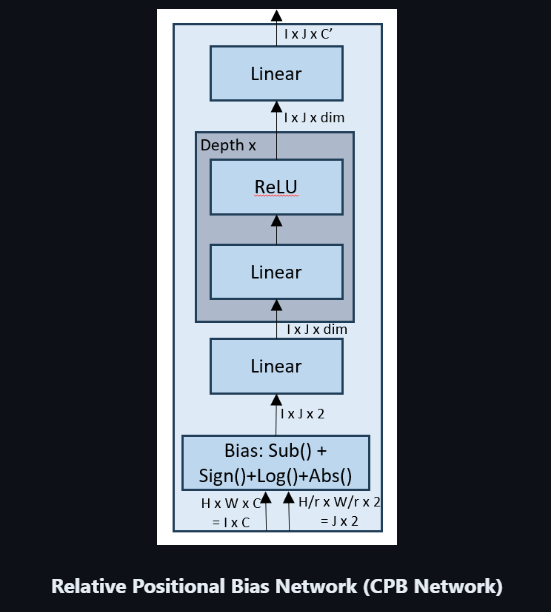

- **Code**:

Please check the implementation in `./python/needle/nn/nn_deform_attention.py`. The class name is "CPB". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of a formal implementation of Deformable Attention (Lucidrain).

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_compare_lucid_our_qkv or test_deform_attn_compare_lucid_our_pos_encoding"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 254 items / 244 deselected / 10 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_pos_encoding[cpu-shape0-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_pos_encoding[cpu-shape0-True] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_pos_encoding[cpu-shape1-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_pos_encoding[cpu-shape1-True] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_pos_encoding[cpu-shape2-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare

### 3. Layers
#### 3.1. Deformable Attention Layer
- **Explanation**:

Mathematically, the query ($Q$) generates offsets ($\Delta p$) using an offset network:

$
\Delta p = \text{scale} \cdot \tanh\left(\text{Conv}_{\text{offset}}(Q)\right),
$

The deformed keys and values are then extracted from these shifted points via bilinear interpolation. These deformed features ($\tilde{K}, \tilde{V}$) are used in the self-attention computation:

$
\text{Attention}(Q, \tilde{K}, \tilde{V}) = \text{Softmax}\left(\frac{Q \tilde{K}^\top}{\sqrt{d}} + B\right) \tilde{V},
$

where $B$ represents the deformable relative positional bias. This bias augments attention weights by encoding spatial relations between queries and keys.

By focusing on deformed sampling points rather than processing all spatial regions equally, the deformable attention layer reduces computational overhead and achieves higher flexibility in handling objects of varying sizes and shapes. This mechanism enhances the model's ability to capture long-range dependencies while maintaining efficiency, making it especially suitable for dense prediction tasks like object detection and segmentation.

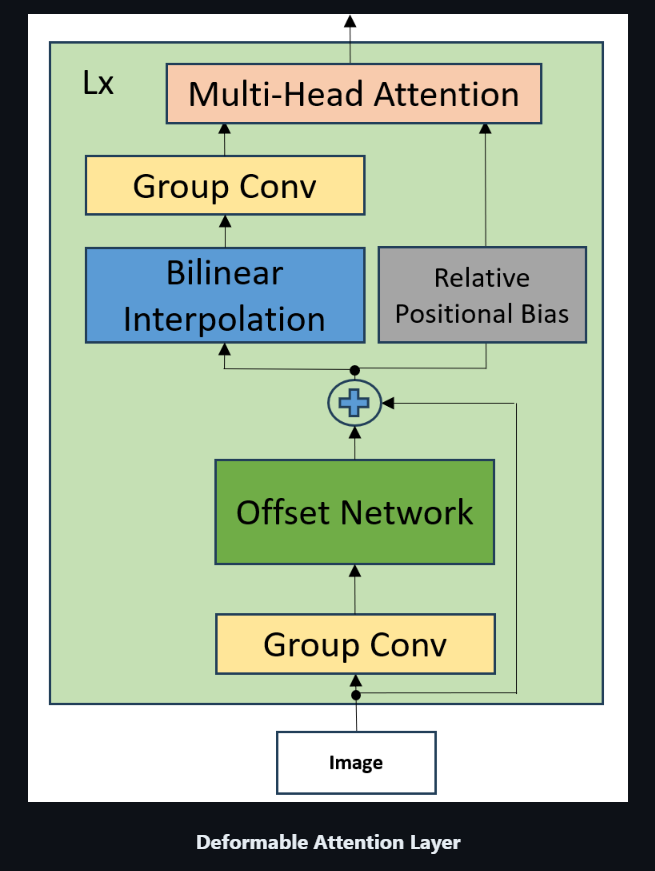

- **Code**:

Please check the implementation in `./python/needle/nn/nn_deform_attention.py`. The class name is "DeformableAttention". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation, which is compared with the output of a formal implementation of Deformable Attention (Lucidrain).
<!--
<div style="border: 2px solid black; padding: 10px; border-radius: 5px; background-color: #FFA500; font-size: 18px; color: black;">
    <strong>Note:</strong> The following tests need 16GB DRAM memory to run, or the process may be killed.
</div>
-->

In [ ]:
!python3 -m pytest ./tests/proj/test_deform_attn.py  -l -v -s -k "test_deform_attn_compare_lucid_our_attn or test_deform_attn_compare_lucid_our_attn_cifar10"

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
BACKEND = nd
collected 254 items / 238 deselected / 16 selected                             

tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_attn_cifar10[cpu-shape0-False-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_attn_cifar10[cpu-shape0-False-True] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_attn_cifar10[cpu-shape0-True-False] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_attn_cifar10[cpu-shape0-True-True] PASSED
tests/proj/test_deform_attn.py::test_deform_attn_compare_lucid_our_attn[cpu-shape0-False-False] PASSED
tests/proj/test_deform_attn.py::test

### 4. Vision Transformer

The vanilla vision transformer is used as our baseline model. We followed the same architecture as the original paper. The model consists of a patch embedding layer, a positional encoding layer, and a transformer encoder. The patch embedding layer is used to convert the input image into a sequence of flattened patches. The positional embedding layer is used to add positional information to the patches. The transformer encoder is used to process the patches and generate the output. The model is trained using the cross-entropy loss function. We will get through each layer in the following sections.

#### 4.1. Patch Embedding Layer
- **Explanation**:

The patch embedding layer takes the input (B, C, H, W) and returns the output (B, N, D), where B is the batch size, C is the number of channels, H is the height of the image, W is the width of the image, N is the number of patches, and D is the dimension of the patch embedding. It first splits the input into non-overlapping patches and then flattens each patch into a vector. A linear layer is used to map the flattened patches to the patch embedding.
Note that we first tried to use the convolutional layer to extract the patches, which is a more elegant way to implement. However, we met some shape issues when calculating the backward pass with even number of strides and even size of kernels. Therefore, we decided to implement this layer with multiple for loops with stack and split operations.

- **Code**:

Please check the implementation in `./python/needle/nn/nn_ViT.py`. The class name is "PatchEmbedding". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation.

In [ ]:
!python3 -m pytest ./tests/proj/test_ViT.py -l -v -k "patch_embedding" -s

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
collected 8 items / 4 deselected / 4 selected                                  

tests/proj/test_ViT.py::test_patch_embedding[cpu-img_size0-16-3-768-4] PASSED
tests/proj/test_ViT.py::test_patch_embedding[cpu-img_size0-16-3-768-8] PASSED
tests/proj/test_ViT.py::test_patch_embedding[cpu-img_size1-4-3-64-4] PASSED
tests/proj/test_ViT.py::test_patch_embedding[cpu-img_size1-4-3-64-8] PASSED

======================= 4 passed, 4 deselected in -0.15s =======================


#### 4.2. Vision Transformer Block
- **Explanation**:

We built the vision transformer block on top of the transformer encoder implemented in previous homeworks. We followed the structure proposed in the original vision transformer paper. The block consists of layer normalization, multi-head self-attention, and feed-forward layers, as illustrated in previous figure. The block takes the input (B, N, D) and returns the output (B, N, D), where B is the batch size, N is the number of patches plus a classification token, and D is the dimension of the patch embedding.

- **Code**:

Please check the implementation in `python/needle/nn/nn_ViT.py`. The class name is "VisionTransformerBlock". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation.

In [ ]:
!python3 -m pytest ./tests/proj/test_ViT.py -l -v -k "vision_transformer_block" -s

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
collected 8 items / 6 deselected / 2 selected                                  

tests/proj/test_ViT.py::test_vision_transformer_block[cpu-0.0-65-16-1-16-64-2] PASSED
tests/proj/test_ViT.py::test_vision_transformer_block[cpu-0.0-65-16-1-16-64-4] PASSED

======================= 2 passed, 6 deselected in 0.61s ========================


#### 4.3. Vision Transformer
- **Explanation**:

We built the vision transformer model with all the components implemented above. The model consists of a patch embedding layer, a positional encoding layer, and a stack of vision transformer blocks. We defined the positional embedding layer in this module, and we also implemented the classification token as used in the original paper. The attended classification token is finally fed into a classification decoder to output the final classification result. The model takes the input (B, C, H, W) and returns the output (B, NC), where B is the batch size, C is the number of channels, H is the height of the image, W is the width of the image, NC is the number of classes. The model is trained using the cross-entropy loss function.

- **Code**:

Please check the implementation in `python/needle/nn/nn_ViT.py`. The class name is "VisionTransformer". The implementation supports Autodiff.

- **Test Code**:

Please run the following cell to check the correctness of the implementation.

In [ ]:
!python3 -m pytest ./tests/proj/test_ViT.py -l -v -k "vision_transformer" -s

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /root/anaconda3/envs/hw4_env/bin/python3
cachedir: .pytest_cache
rootdir: /CMU_10714_Work/CMU_10714_Deep_Learning_Systems/final_project/ViTNeedle
collecting ... Using needle backend
collected 8 items / 4 deselected / 4 selected                                  

tests/proj/test_ViT.py::test_vision_transformer_block[cpu-0.0-65-16-1-16-64-2] PASSED
tests/proj/test_ViT.py::test_vision_transformer_block[cpu-0.0-65-16-1-16-64-4] PASSED
tests/proj/test_ViT.py::test_vision_transformer[cpu-0.0-6-img_size0-4-3-10-16-1-16-64-4] PASSED
tests/proj/test_ViT.py::test_vision_transformer[cpu-0.0-6-img_size0-4-3-10-16-1-16-64-8] PASSED

======================= 4 passed, 4 deselected in 2.62s ========================


## Experiments


### 1. Preparing the Dataset: CIFAR-10 Dataset

In the experiments, we use **CIFAR-10 Dataset**. The **CIFAR-10 dataset** is a widely used benchmark dataset in the field of computer vision, designed to evaluate image classification algorithms. It consists of 60,000 color images of size $32 \times 32$, divided into 10 distinct classes: airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Each class contains 6,000 images, ensuring a balanced distribution across the dataset. Of the total images, 50,000 are used for training, while 10,000 are reserved for testing, allowing researchers to evaluate the performance of their models on unseen data.

Each image in CIFAR-10 is represented as a small $32 \times 32$ RGB image, where the three color channels (Red, Green, and Blue) contain pixel intensity values ranging from 0 to 255. This small size makes it computationally efficient for both training and evaluation, enabling quick experimentation even on resource-constrained hardware. Despite its simplicity, the dataset is diverse enough to capture variations in object appearances, poses, and backgrounds, providing a moderate challenge for classification models. Overall, CIFAR-10 remains a critical dataset for developing and evaluating modern computer vision algorithms due to its balance of simplicity and diversity.

Please run the following cell of code. It will create a 'data' folder for you, if not existed, and download, unsqueeze and put the whole dataset in the folder for further usage.

In [ ]:
%matplotlib inline
from IPython.display import Image
import urllib.request
import os

# Check if the folder exists
if not os.path.exists('data'):
    # If not, create the folder
    os.makedirs('data')
    print(f"Folder 'data' created.")

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

### 2. Baseline Model (Vanilla ViT) vs Deformable Attention Model (Deformable ViT)

This experiment compares the performance of two models implemented in Needle: a baseline model (a) using standard vanilla attention and a deformable attention model (b) using the deformable attention introduced above. Both models are evaluated on the CIFAR-10 dataset under identical experimental settings to highlight the impact of the deformable attention mechanism.

#### Experimental Parameters:
- **Dataset**: CIFAR-10
  - Training Set Size: 50,000 images
  - Testing Set Size: 10,000 images
  - Image Size: $32 \times 32 \times 3$
- **Batch Size**: 64
  - Number of Training Batches: 782 batches
  - Number of Testing Batches:  157 batches
- **Patch Size**: $4 \times 4$
- **Embedding Dimension**: 64
- **Attention Settings**:
  - Number of Heads in Vanilla Attention: 8
  - Number of Heads in Deformable Attention: 2
  - Channels of Deformable Attention: 8
- **Device**: CPU

#### Model Architectures:
1. **Baseline Model (a)**:
   - Uses standard vanilla attention in the transformer encoder layers.
   - Includes a patching and embedding layer before the transformer encoders.

2. **Deformable Attention Model (b)**:
   - Incorporates a deformable attention layer to improve attention efficiency and focus.
   - Similar patching and embedding process as the baseline, but with added deformable attention layers.

The models are trained and evaluated under these controlled conditions to demonstrate the benefits of deformable attention in reducing computational complexity while maintaining or improving classification performance.

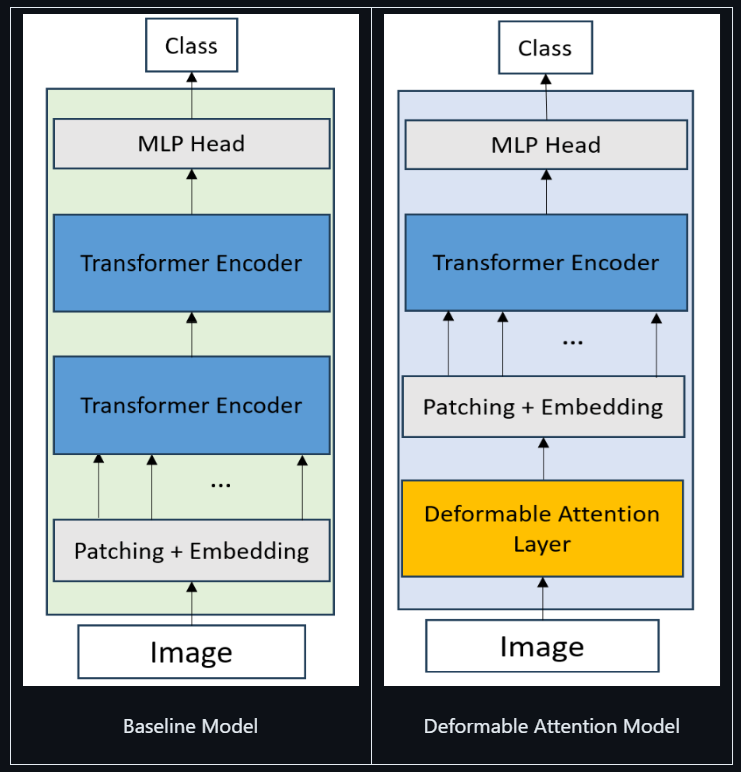

Run the following cell, the code will train (a) and (b) models and display the figures of training accuracy and loss versus epochs comparing the performance of the two models. The standard output prints the epoch number along with the progress hint expressed by the number of batches (the numerator) and the number of images (the denominator).

Using needle backend
len(train_dataset) = 50000
len(test_dataset) = 10000
in_channels_base = 3
in_channels_dattn = 8
len(self.attn.parmeters) = 16768
len(self.dattn.parmeters) = 334
len(self.base_model.parmeters) = 74954
len(self.dattn_model.parmeters) = 47160
782it [34:55,  2.68s/it]
Training, Epoch 1: avg_acc=0.312, avg_loss=1.903
  2%|▌                                   | 782/50000 [35:08<36:52:08,  2.70s/it]
Training, Epoch 2: avg_acc=0.474, avg_loss=1.442
  2%|▌                                   | 782/50000 [35:16<37:00:31,  2.71s/it]
Training, Epoch 3: avg_acc=0.522, avg_loss=1.318
  2%|▌                                   | 782/50000 [35:16<36:59:50,  2.71s/it]
Training, Epoch 4: avg_acc=0.549, avg_loss=1.246
  2%|▌                                   | 782/50000 [35:27<37:11:46,  2.72s/it]
Training, Epoch 5: avg_acc=0.568, avg_loss=1.195
  2%|▌                                   | 782/50000 [35:37<37:22:22,  2.73s/it]
Training, Epoch 6: avg_acc=0.584, avg_loss=1.155
  2%|▌         

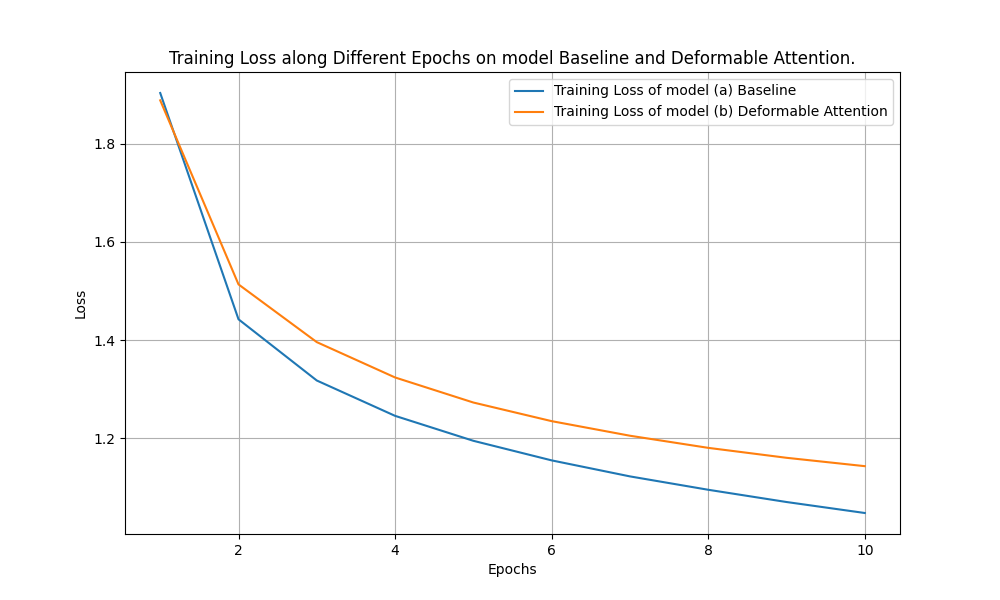

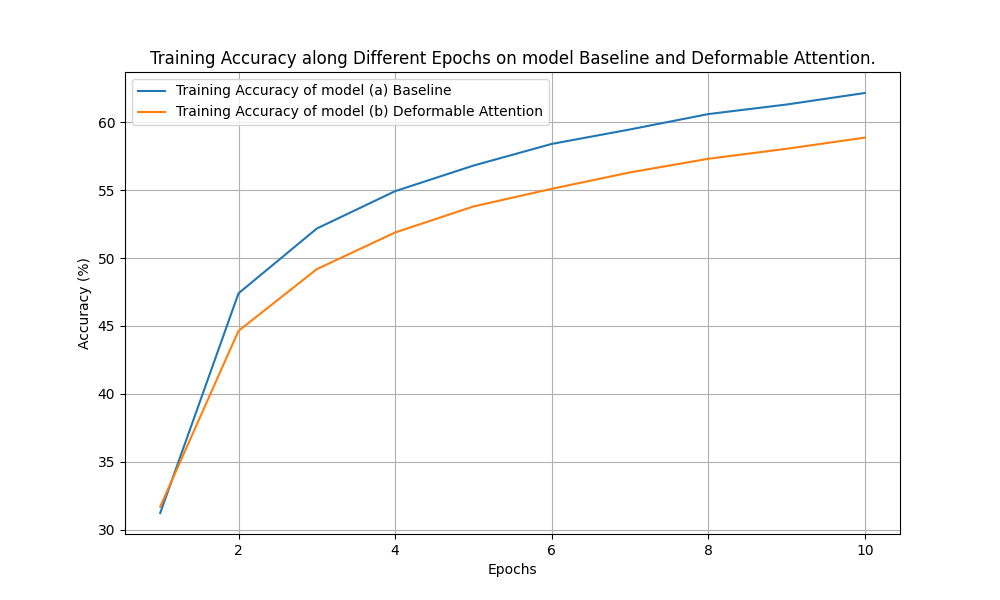

In [ ]:
!python3 ./apps/ViT_train_plot_b2d.py

display(Image(filename='training_loss_b2d.png'))
display(Image(filename='training_accuracy_b2d.png'))

Run the following cell of code to see how the number of channels affect the number of learning parameters and the performance of the Deformable Attention Model. The standard output prints the epoch number along with the progress hint expressed by the number of batches (the numerator) and the number of images (the denominator).

Using needle backend
len(train_dataset) = 50000
len(test_dataset) = 10000
dattn_model_ch4.dattn.parmeters) = 126
dattn_model_ch8.dattn.parmeters) = 334
dattn_model_ch16.dattn.parmeters) = 1620
dattn_model_ch4.parmeters = 42744
dattn_model_ch8.parmeters = 47160
dattn_model_ch16.parmeters = 56862
782it [52:29,  4.03s/it]
Training, Epoch 1: avg_acc=0.277, avg_loss=1.982
  2%|▌                                   | 782/50000 [52:59<55:35:41,  4.07s/it]
Training, Epoch 2: avg_acc=0.390, avg_loss=1.648
  2%|▌                                   | 782/50000 [52:25<54:59:59,  4.02s/it]
Training, Epoch 3: avg_acc=0.451, avg_loss=1.503
  2%|▌                                   | 782/50000 [52:12<54:46:26,  4.01s/it]
Training, Epoch 4: avg_acc=0.486, avg_loss=1.410
  2%|▌                                   | 782/50000 [52:20<54:54:42,  4.02s/it]
Training, Epoch 5: avg_acc=0.512, avg_loss=1.343
  2%|▌                                   | 782/50000 [53:45<56:23:29,  4.12s/it]
Training, Epoch 6: avg_acc=0.

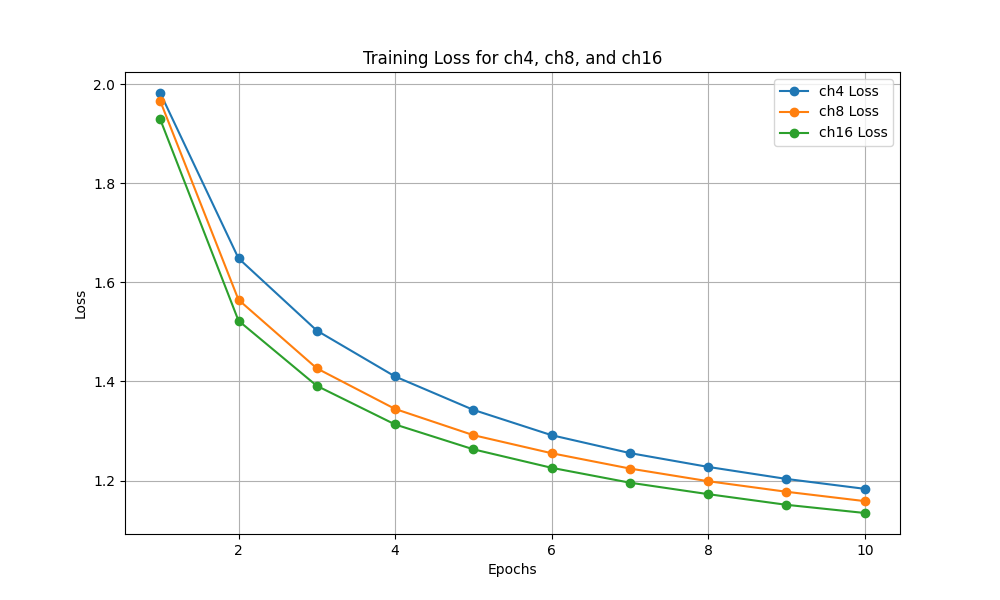

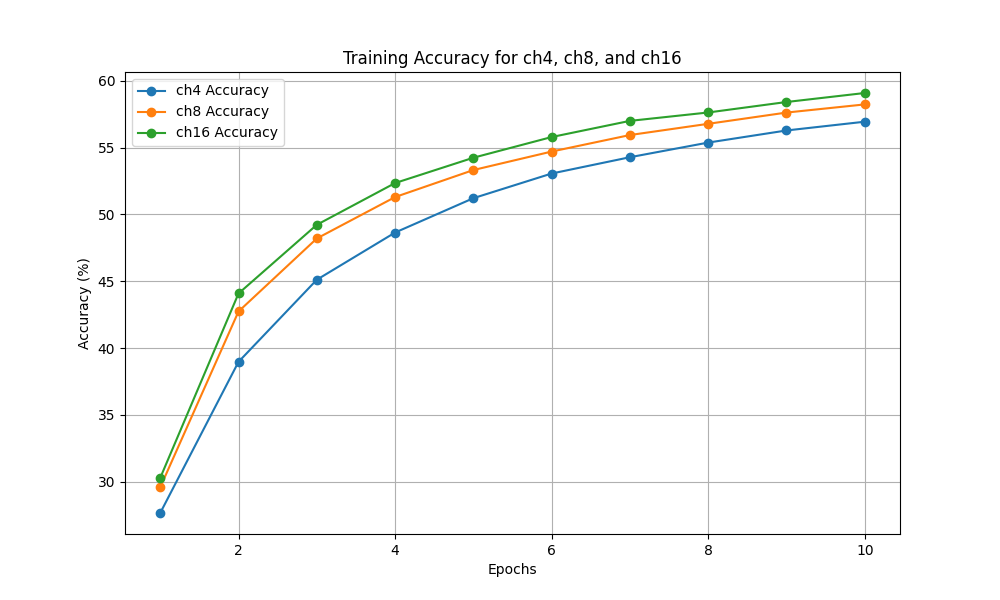

In [ ]:
!python3 ./apps/ViT_train_plot_d2d.py

display(Image(filename='training_loss_d2d.png'))
display(Image(filename='training_accuracy_d2d.png'))


## Concolusions

### From above experiments, we have the following findings:

- #### 1. The deformable attention layer significantly reduces the number of parameters compared to the baseline vanilla attention layer (334 vs 16768) , making it well-suited for resource-constrained platforms.
- #### 2. With 50% fewer parameters, the Deformable Attention Model still achieves similar accuracy in training (58.9% vs. 62.1%) and testing (57.1% vs. 58.5%) compared with the Baseline Model.
- #### 3. The Deformable Attention Model requires nearly twice the computation time per iteration (2.74s vs. 5.58s) than the Baseline Model, highlighting the increased computational complexity associated with the additional subnetworks and operations for region of interest detection in deformable attention layer.
- #### 4. As the channel number of deformable attention layer changes from 4 to 8 to 16, we can see from above figures that the training accuracy and loss are getting better, and the testing accuracy is also getting better: increasing from 55.3% to 56.3% to 58.1%.
- #### 5. Increasing the number of channels in the deformable attention layer enhances the model's capacity by adding more learnable parameters, enabling it to capture complex features and improve accuracy. However, this comes with increased computational cost, time per iteration increases from 4.01s to 5.46s to 7s for channels 4, 8 and 16, requiring a balance between performance and efficiency.

## References
<a name="ref1"></a> [1] Dosovitskiy, Alexey, et al., "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale," ICLR 2021.  
<a name="ref2"></a> [2] Z. Xia, et al., "Vision Transformer with Deformable Attention," CVPR 2022.